# Modern Portfolio Theory

We want to use modern portfolio theory (MPT) for identification of optimal portfolios consisting of various crypto assets.

## Import Data

In [24]:
# import basic modules
import numpy as np
import pandas as pd
import datetime as dt
import warnings

# filter warnings
warnings.filterwarnings("ignore")

In [25]:
# import data from yahoo finance using the pandas data-reader
from pandas_datareader import data as pdr
def getData(assets, start, end):
    data = pdr.get_data_yahoo(assets, start = start, end = end)
    data = data["Adj Close"] # select adjusted closing price
    return data

In [26]:
# select assets to use
data_list = ["BTC-USD", "ETH-USD", "ADA-USD", "LINK-USD", "BNB-USD"]

In [27]:
# set start and end date for data collection
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*3)

In [28]:
# create dataframe
df = getData(data_list, start = startDate, end = endDate)
print(df)

Symbols          BTC-USD      ETH-USD   ADA-USD   LINK-USD     BNB-USD
Date                                                                  
2018-03-22   8728.469727   539.702026  0.203481   0.419292   10.066300
2018-03-23   8879.620117   539.619019  0.189259   0.409140   11.737600
2018-03-24   8668.120117   526.439026  0.189201   0.419085   13.089100
2018-03-25   8495.780273   524.286987  0.184605   0.406105   12.783100
2018-03-25   8209.400391   489.950989  0.167806   0.371496   12.061400
...                  ...          ...       ...        ...         ...
2021-03-17  58870.894531  1823.449341  1.378673  31.009760  269.854858
2021-03-18  57858.921875  1782.855103  1.239006  29.504812  261.704803
2021-03-19  58346.652344  1817.624146  1.302170  29.909876  264.057434
2021-03-20  58313.644531  1812.634644  1.206541  29.676926  264.741669
2021-03-21  56268.421875  1770.581421  1.180120  28.972692  259.590057

[1092 rows x 5 columns]


## Data Exploration

Comparing and visualizing distributions of asset returns and checking for skewness and kurtosis.

Skewness: $\frac{1}{n}\sum^{n}_{t=1}\frac{(r_{t}-\bar{r})^3}{s^3}$, Kurtosis: $\frac{1}{n}\sum^{n}_{t=1}\frac{(r_{t}-\bar{r})^4}{s^4}$

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from matplotlib.pyplot import plot

# use higher resolution for plots
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# scipy for computing skewness and kurtosis
import scipy.stats as stats

In [30]:
#create function for easy plotting
def multiPlot(asset):
    # distribution plot using simple returns
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
    sns.histplot(asset.pct_change().iloc[1:], ax = ax[0], bins = 30, color = "lightcyan", stat = "density")
    sns.kdeplot(asset.pct_change().iloc[1:], ax = ax[0], color = "blue", linestyle = "--", label = "Kernel Density")
    ax[0].set_xlim(-0.3, 0.3)
    ax[0].set_xlabel("Simple Returns")
    ax[0].set_title("Histogram of simple returns")
    
    # compute normal distribution for comparison with asset distributions
    mean, std = stats.norm.fit(asset.pct_change().iloc[1:])
    x = np.linspace(-0.3, 0.3, 300)
    p = stats.norm.pdf(x, mean, std)
    ax[0].plot(x, p, "r", linewidth = 2, label = "Normal")
    ax[0].legend()

    # probability plot
    stats.probplot(asset.pct_change().iloc[1:], dist = "norm", rvalue = True, fit = True, plot = plt)
    plt.xlabel("Normal Distribution")
    plt.ylabel("Sample Distribution")

Recall that a normal distribution in the form of $f(x)=\frac{1}{\sigma \sqrt{2\pi}}\exp\left[ -\frac{(x-\mu)^2}{2\sigma^2} \right]$ has a skewness of 0 and a kurtosis of 3.

### Bitcoin (BTC)
Bitcoin is a decentralized digital currency, without a central bank or single administrator, that can be sent from user to user on the peer-to-peer bitcoin network without the need for intermediaries. Transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain. Bitcoins are created as a reward for a process known as mining.

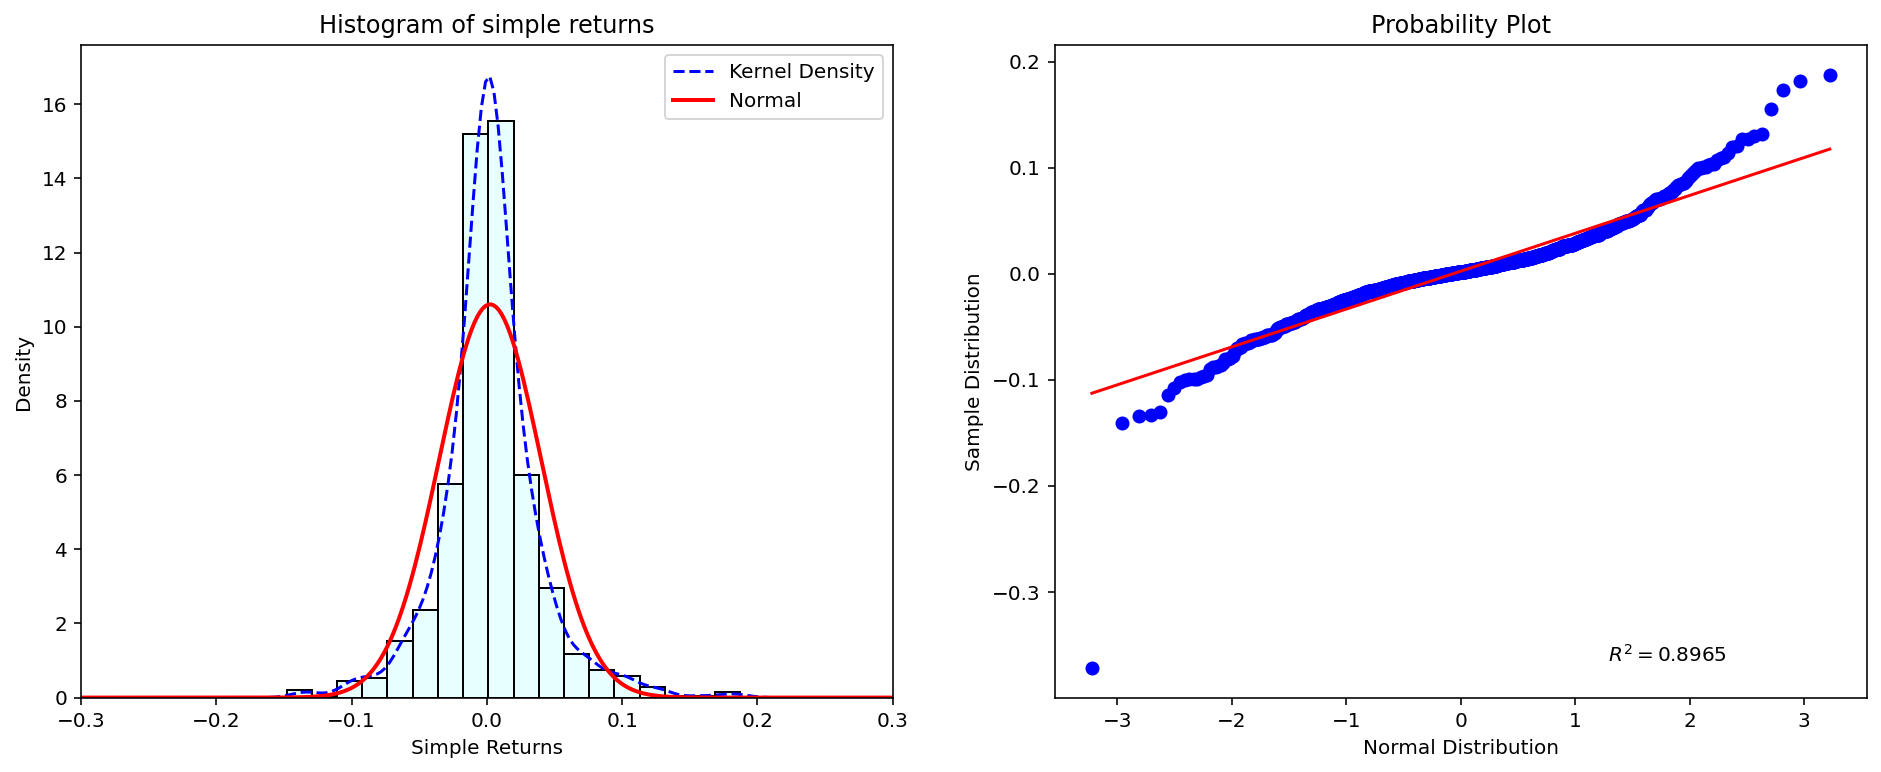

In [31]:
multiPlot(df["BTC-USD"])

In [32]:
print("BTC distribution skewness: " + str(stats.skew(df["BTC-USD"].pct_change().iloc[1:])))
print("BTC distribution kurtosis: " + str(stats.kurtosis(df["BTC-USD"].pct_change().iloc[1:])))

BTC distribution skewness: -0.5092530012194719
BTC distribution kurtosis: 11.408496095336675


### Ethereum (ETH)
Ethereum is a decentralized, open-source blockchain with smart contract functionality. Ether (ETH) is the native cryptocurrency of the platform. It is the second-largest cryptocurrency by market capitalization, after Bitcoin. Ethereum is the most actively used blockchain.

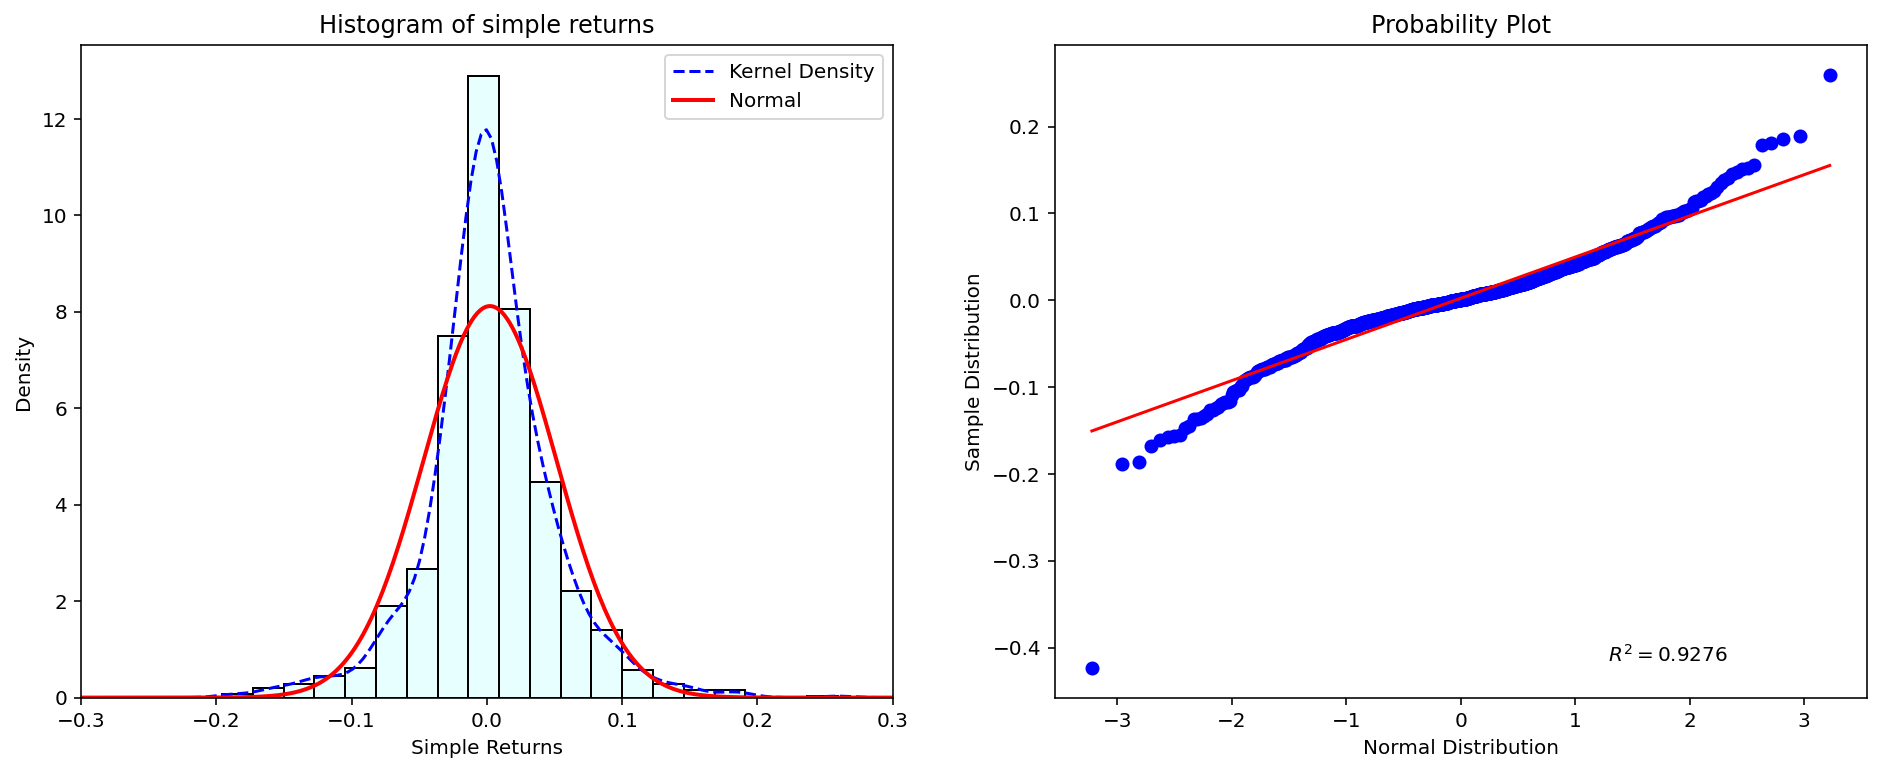

In [33]:
multiPlot(df["ETH-USD"])

In [34]:
print("ETH distribution skewness: " + str(stats.skew(df["ETH-USD"].pct_change().iloc[1:])))
print("ETH distribution kurtosis: " + str(stats.kurtosis(df["ETH-USD"].pct_change().iloc[1:])))

ETH distribution skewness: -0.47726435737605377
ETH distribution kurtosis: 7.218611882672661


### Cardano (ADA)
Cardano is a cryptocurrency network and open source project that aims to run a public blockchain platform for smart contracts. Cardano's internal cryptocurrency is called ADA. The development of the project is overseen and supervised by the Cardano Foundation based in Zug, Switzerland. Cardano uses Ouroboros proof of stake technology. In contrast, Bitcoin uses the proof of work system; the first blockchain entry and the longest blockchain (blockchain with the most computing power) is used to determine the honest blockchain. Cardano uses only the first blockchain entry, whereafter the honest chain is proven locally without the need of a trusted party.

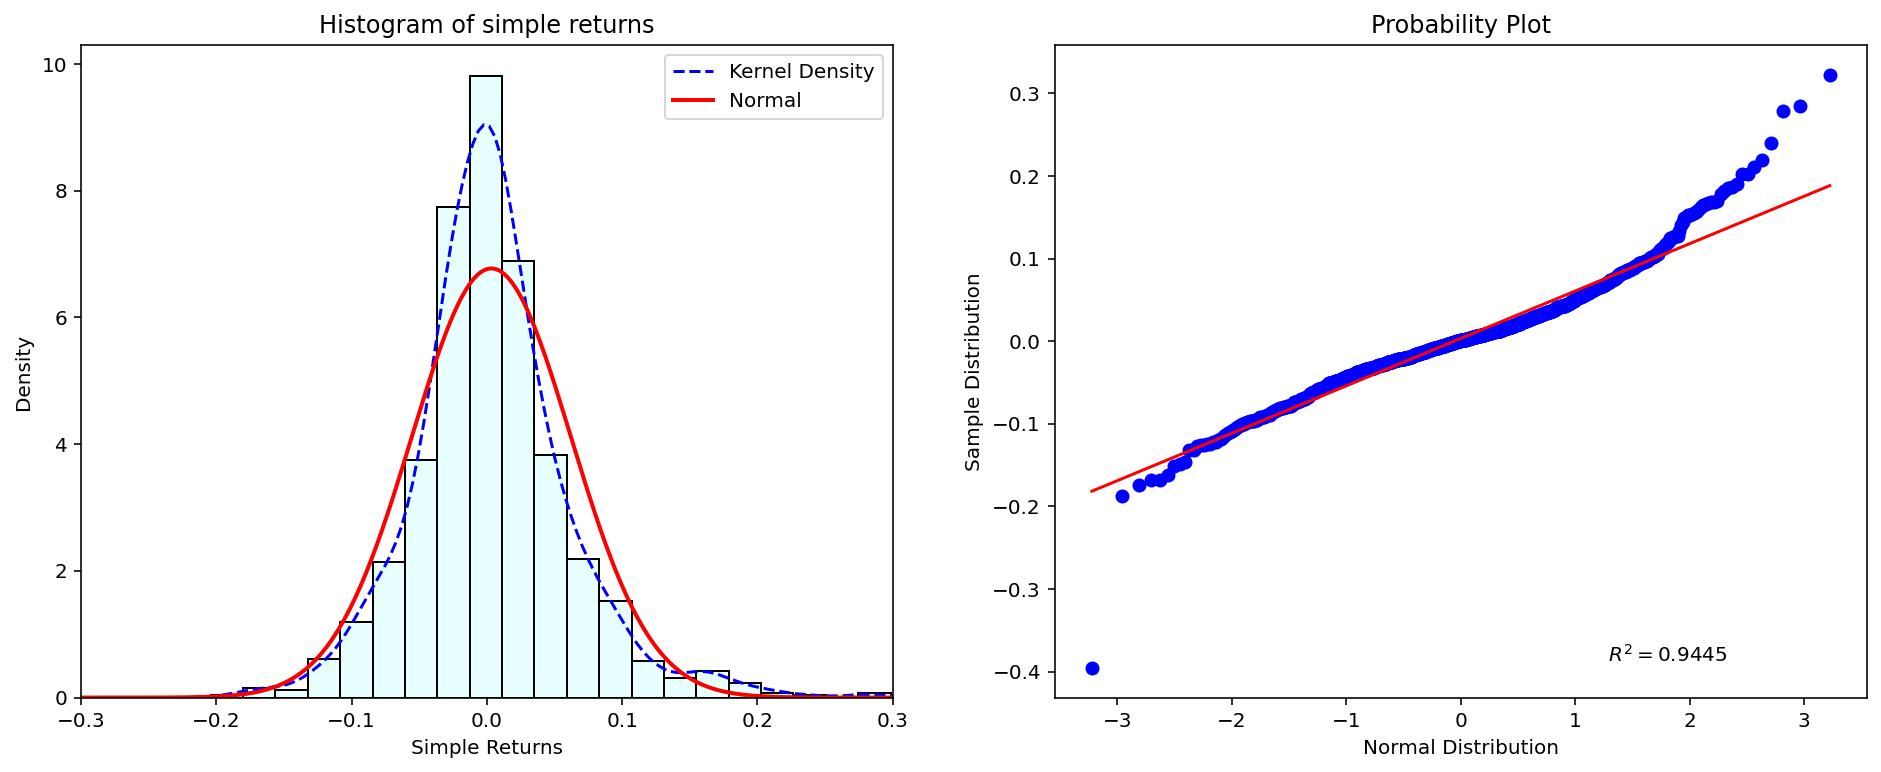

In [35]:
multiPlot(df["ADA-USD"])

In [36]:
print("ADA distribution skewness: " + str(stats.skew(df["ADA-USD"].pct_change().iloc[1:])))
print("ADA distribution kurtosis: " + str(stats.kurtosis(df["ADA-USD"].pct_change().iloc[1:])))

ADA distribution skewness: 0.42102809494858157
ADA distribution kurtosis: 4.354513335974476


### Chainlink (LINK)
Chainlink’s technology claims to solve one of the biggest challenges for the practical implementation of smart contracts – connecting blockchains to real world data – such as price feeds or delivery confirmations – through so-called oracles blockchain connectivity.

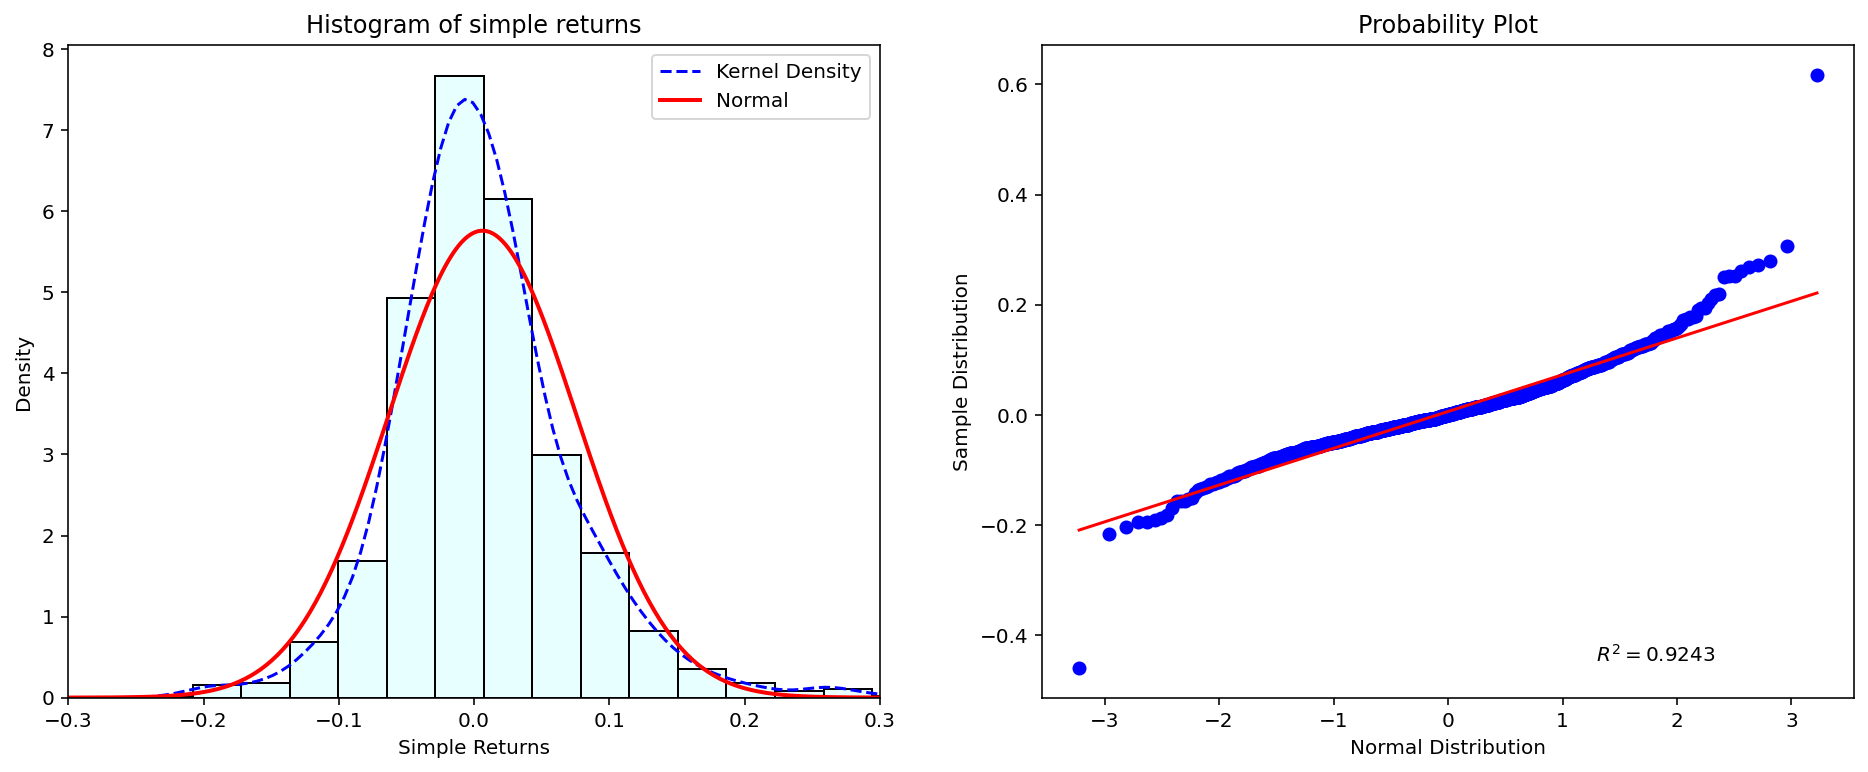

In [37]:
multiPlot(df["LINK-USD"])

In [38]:
print("LINK distribution skewness: " + str(stats.skew(df["LINK-USD"].pct_change().iloc[1:])))
print("LINK distribution kurtosis: " + str(stats.kurtosis(df["LINK-USD"].pct_change().iloc[1:])))

LINK distribution skewness: 0.8468759278922738
LINK distribution kurtosis: 8.416533265145196


### Binance Coin (BNB)
BNB powers the Binance Ecosystem. As the native coin of Binance Chain, BNB has multiple use cases: fueling transactions on the Chain, paying for transaction fees on Binance Exchange, making in-store payments, and many more. Although initially based on the Ethereum network, the ERC-20 BNB tokens were later swapped with BEP-2 BNB on a 1:1 ratio. The BEP-2 BNB is the native coin of the Binance Chain.

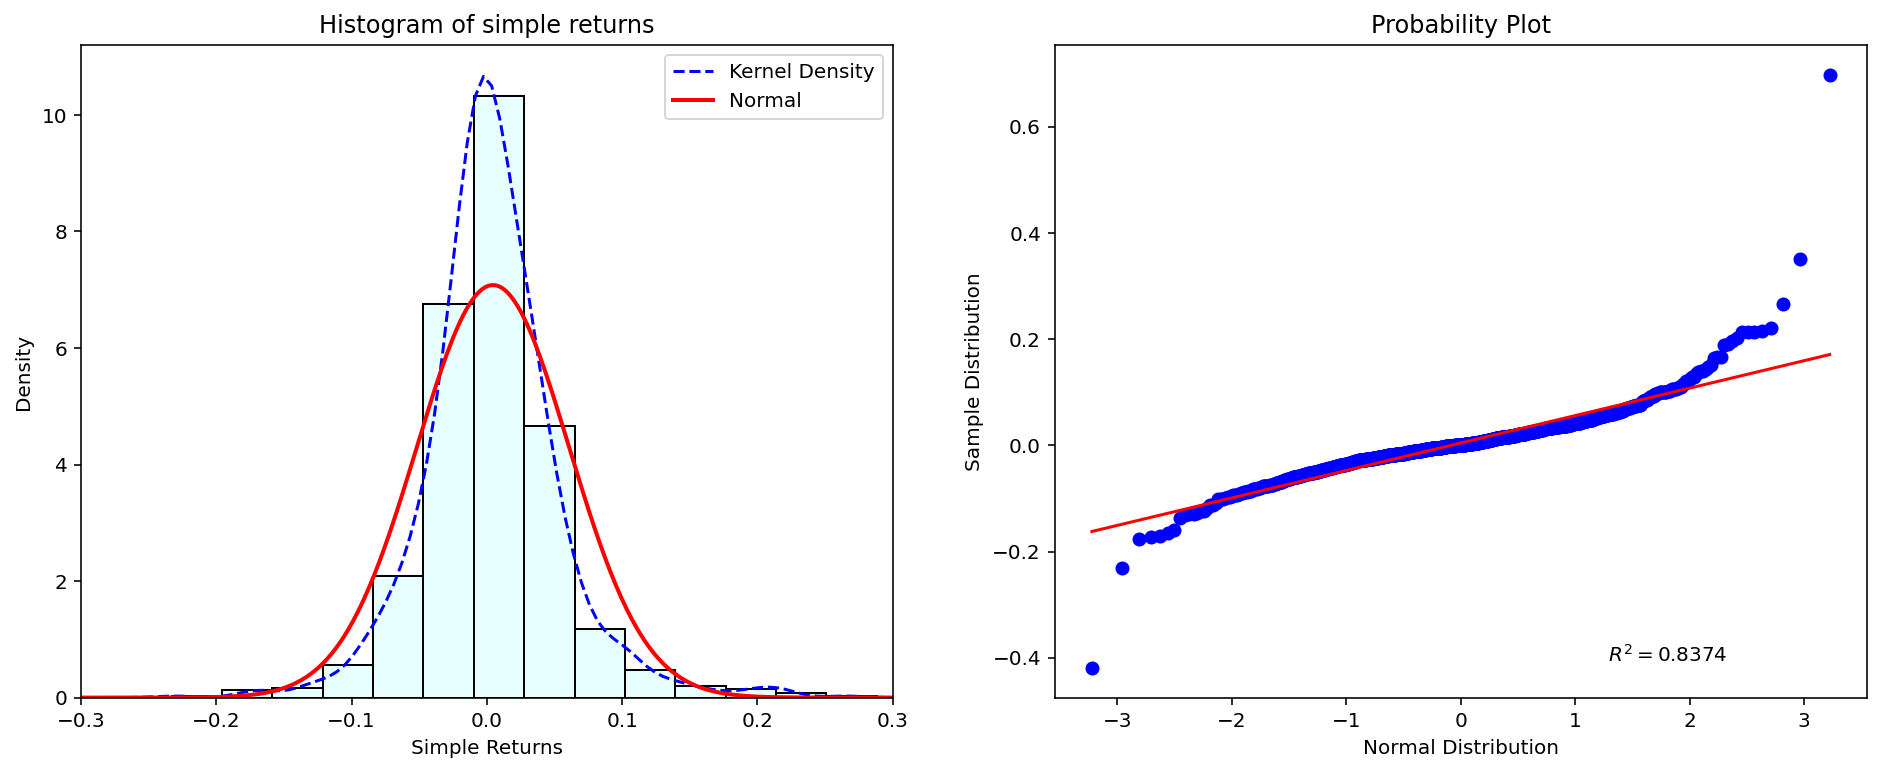

In [39]:
multiPlot(df["BNB-USD"])

In [40]:
print("BNB distribution skewness: " + str(stats.skew(df["BNB-USD"].pct_change().iloc[1:])))
print("BNB distribution kurtosis: " + str(stats.kurtosis(df["BNB-USD"].pct_change().iloc[1:])))

BNB distribution skewness: 1.869426386633647
BNB distribution kurtosis: 26.228310023944978


## Mean-Variance-Optimization (MVO)

MVO is the process of weighing risk, expressed as variance, against expected return. We'll use the package `PyPortfolioOpt` for all our calculations.

### Calculate Annual Mean Return Vector $\mu$

First we need to calculate the annual mean returns for each asset using the geometric mean:
$\bar{r} = [(1+r_{1}) \cdot (1+r_{2}) \cdots (1+r_{n})]^{365/n} - 1$

$$\mu = \begin{pmatrix} \bar{r}_{1} \\ \bar{r}_{2} \\ \bar{r}_{3} \\ \vdots \\ \bar{r}_{n} \\ \end{pmatrix}$$

In [41]:
from pypfopt import expected_returns
mu = expected_returns.mean_historical_return(df, compounding = True, frequency = 365)
print("Vector of mean returns:")
print(mu)

Vector of mean returns:
Symbols
BTC-USD     0.865368
ETH-USD     0.488051
ADA-USD     0.800530
LINK-USD    3.124825
BNB-USD     1.966181
dtype: float64


### Compute Variance-Covariance Matrix $\Sigma$

In addition to the expected returns, MVO requires a risk model, some way of quantifying asset risk. We'll use the classic covariance-matrix first.

Whereas the sample covariance between two assets $x$ and $y$ can be denoted as: $\;\text{Cov}(x,y) = \sigma_{xy} = \frac{1}{N-1}\sum^N_{i=1}(x_{i}-\bar{x})(y_{i}-\bar{y})$, and the basic sample variance of an asset can be expressed as $\sigma^2 = \frac{1}{N-1}\sum^N_{i=1}(x_{i}-\bar{x})^2$.

$$\Sigma = \begin{pmatrix} \sigma^2_{1} & \sigma_{12} & \cdots & \sigma^2_{1n} \\ \sigma_{21} & \sigma^2_{2} & \cdots & \sigma_{2n} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{n1} & \sigma_{n2} & \cdots & \sigma^2_{n} \end{pmatrix}$$

In [42]:
from pypfopt.risk_models import sample_cov
sigma = sample_cov(df)
print(sigma)

Symbols    BTC-USD   ETH-USD   ADA-USD  LINK-USD   BNB-USD
Symbols                                                   
BTC-USD   0.357103  0.380505  0.374583  0.339965  0.324063
ETH-USD   0.380505  0.608758  0.562535  0.511911  0.434070
ADA-USD   0.374583  0.562535  0.875328  0.546865  0.460030
LINK-USD  0.339965  0.511911  0.546865  1.209606  0.442710
BNB-USD   0.324063  0.434070  0.460030  0.442710  0.800783


### Efficient Frontier

The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return. We can plot the efficient frontier by defining $\mu_{p}=\mu^{T}w$ as the expected return and $\sigma^2_{p}=w^{T}\Sigma w$ as the volatility of the respected portfolio, the weights $w$ are initialized randomly at first.

After visualizing the efficient frontier, we want to find two specific portfolios: the portfolio with the maximum sharpe-ratio and the portfolio with the minimum volatility.

$$\text{Minimum Volatility: } \min_{w} \{w^{T}\Sigma w\}$$

$$\text{Maximum Sharpe-Ratio: } \max_{w} \left\{ \frac{\mu^{T}w - r_{f}}{w^{T}\Sigma w} \right\}$$

In [43]:
# generate n random portfolios for plotting
n = 20000
w = np.random.dirichlet(np.ones(len(mu)), n) # weights

# compute returns and volatility
returns = w.dot(mu)
variance = np.sqrt(np.diag(w @ sigma @ w.T))

# compute sharpe-ratio
sharpe_ratio = (returns - 0.02) / variance

In [44]:
from matplotlib.gridspec import GridSpec
from pypfopt.efficient_frontier import EfficientFrontier

# tell piecharts to only show weights > 0
def my_autopct(pct):
    return ("%.0f" % pct) if pct > 0 else "" 

# function for plotting the efficient frontier
def plotEF(returns, variance, mu, sigma, labels_list):
    max_sharpe = EfficientFrontier(mu, sigma, weight_bounds = (0,1))
    max_sharpe.max_sharpe() # maximum sharpe-ratio
    returns_ms, variance_ms, _ = max_sharpe.portfolio_performance()

    min_vola = EfficientFrontier(mu, sigma, weight_bounds = (0,1))
    min_vola.min_volatility() # minimum volatility
    returns_mv, variance_mv, _ = min_vola.portfolio_performance()

    fig = plt.figure(figsize = (18, 8))
    gs = GridSpec(nrows = 2, ncols = 2, wspace = -0.2)
    
    ax0 = fig.add_subplot(gs[:,0])
    ax0.scatter(variance, returns, marker = ".", c = sharpe_ratio, cmap = "plasma")
    ax0.scatter(variance_ms, returns_ms, marker = ".", s = 700, c = "b", label = "Maximum Sharpe-Ratio")
    ax0.scatter(variance_mv, returns_mv, marker = ".", s = 700, c = "g", label = "Minimum Volatility")
    ax0.set_title("Efficient Frontier")
    ax0.set_xlabel("Volatility")
    ax0.set_ylabel("Returns")
    ax0.legend(frameon = False, borderpad = 1.5, labelspacing = 1)
    
    # plot piechart of portfolio with minimum volatility
    ax1 = fig.add_subplot(gs[0,1])
    ef_mv = EfficientFrontier(mu, sigma)
    weights_mv = ef_mv.min_volatility()
    pd.Series(weights_mv).plot.pie(labels = labels_list, autopct = my_autopct)
    plt.ylabel("")
    plt.title("Minimum Volatility Portfolio")

    # plot piechart of portfolio with maximum sharpe-ratio
    ax2 = fig.add_subplot(gs[1,1])
    ef_ms = EfficientFrontier(mu, sigma)
    weights_ms = ef_ms.max_sharpe()
    pd.Series(weights_ms).plot.pie(labels = labels_list, autopct = my_autopct)
    plt.ylabel("")
    plt.title("Maximum Sharpe-Ratio Portfolio")

    plt.show()

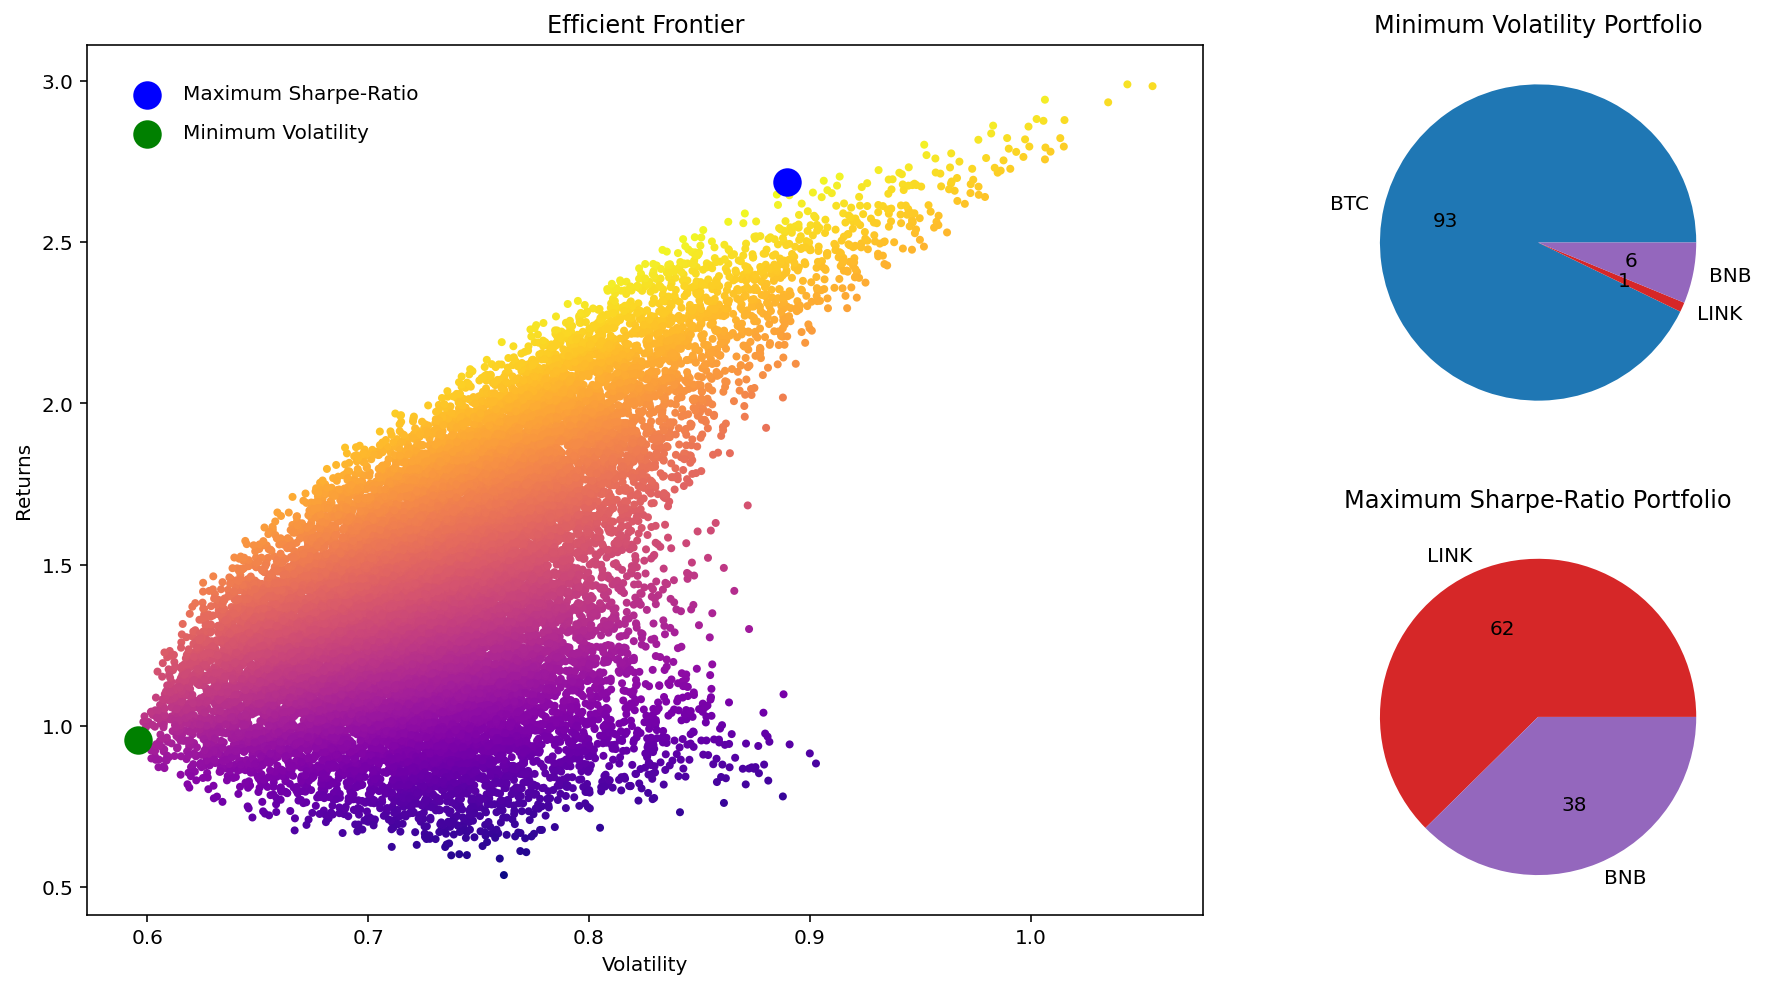

In [45]:
plotEF(returns, variance, mu, sigma, ["BTC", "ETH", "ADA", "LINK", "BNB"])

## MVO + Capital Asset Pricing Model (CAPM)

The CAPM is a model that attempts to describe the relationship between the risk and the expected return of an asset. It is used to determine an investment's appropriate price. The CAPM says that the expected return of a security or a portfolio is equal to the rate on a risk-free security plus a risk premium multiplied by the asset's systematic risk, where the systematic risk is represented by the beta factor $\beta_{i}$. The risk premium can be described as the expected return of the market that is above the risk-free rate $r_{f}$. We'll use the CRIX cryptocurreny index as our market data for the CAPM. The CRIX is realtime computed by the Ladislaus von Bortkiewicz Chair of Statistics at Humboldt University Berlin, Germany.

In [55]:
market_data = pd.read_json("http://data.thecrix.de/data/crix.json")
market_data.set_index("date", inplace = True)
print(market_data)

                    price
date                     
2014-07-31    1000.000000
2014-08-01    1018.202717
2014-08-02    1008.772389
2014-08-03    1004.416500
2014-08-04    1004.984138
...                   ...
2021-03-15  165539.651239
2021-03-16  156291.020042
2021-03-17  158122.757150
2021-03-18  164121.602064
2021-03-19  161113.316266

[2424 rows x 1 columns]


### Distribution of the CRIX

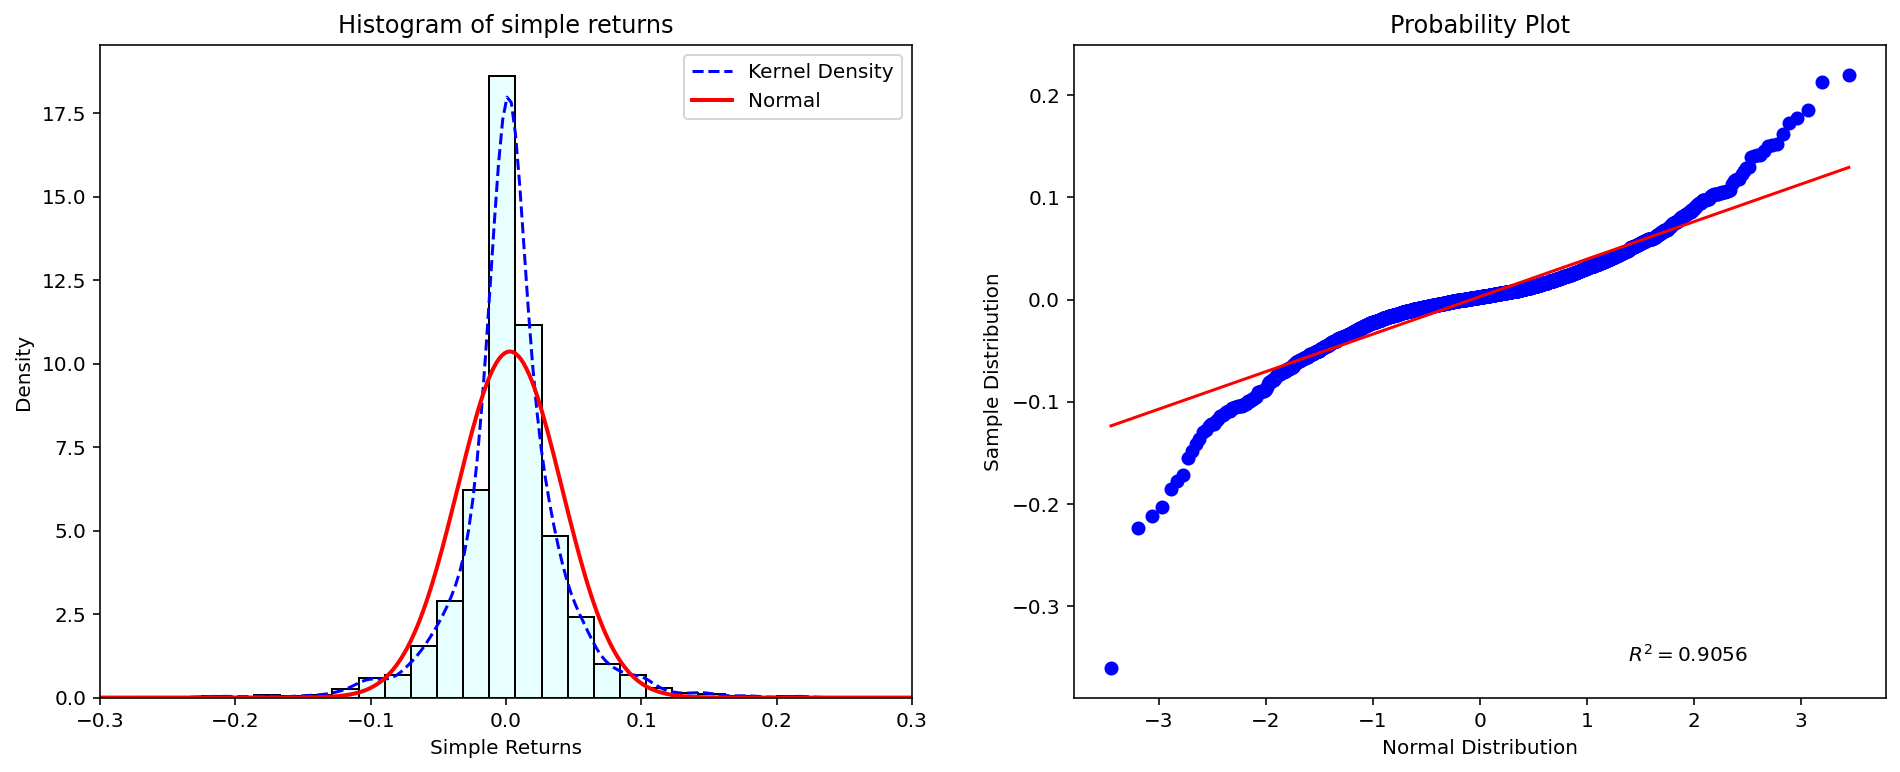

In [56]:
multiPlot(market_data["price"])

In [57]:
print("CRIX distribution skewness: " + str(stats.skew(market_data["price"].pct_change().iloc[1:])))
print("CRIX distribution kurtosis: " + str(stats.kurtosis(market_data["price"].pct_change().iloc[1:])))

CRIX distribution skewness: -0.4045301452016811
CRIX distribution kurtosis: 7.58209611981809


### CAPM using the CRIX

Calculate the expected returns for each asset using the CAPM: $E[r_{i}] = r_{f} + (E[r_{m}]-r_{f})\beta_{i}$

In [26]:
mu_capm = expected_returns.capm_return(df, compounding = True, frequency = 365, market_prices = market_data)
print("Expected returns using benchmark data:")
print(mu_capm)

Expected returns using benchmark data:
BTC-USD     0.013740
ETH-USD     0.018167
ADA-USD    -0.015231
LINK-USD   -0.003739
BNB-USD     0.037931
Name: mkt, dtype: float64


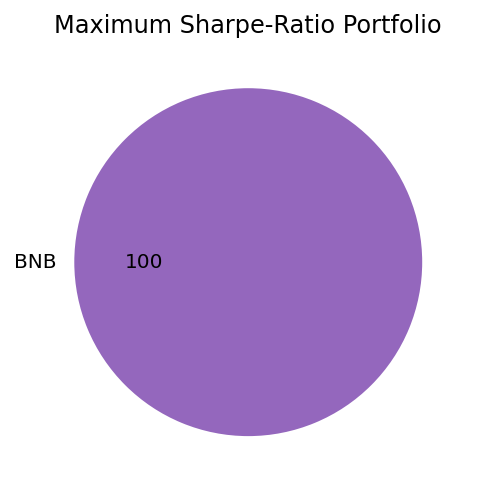

In [27]:
ef_capm = EfficientFrontier(mu_capm, sigma, weight_bounds = (0,1))
weights_capm = ef_capm.max_sharpe()
pd.Series(ef_capm.clean_weights()).plot.pie(labels = ["BTC", "ETH", "ADA", "LINK", "BNB"], autopct = my_autopct)
plt.ylabel("")
plt.title("Maximum Sharpe-Ratio Portfolio");

### CAPM without market data

Not using any market data results in the model using the given returns as a proxy for $E[r_{m}]$.

In [28]:
mu_capm = expected_returns.capm_return(df, compounding = True, frequency = 365)
print("Expected returns not using benchmark:")
print(mu_capm)

Expected returns not using benchmark:
Symbols
BTC-USD     1.227909
ETH-USD     1.720431
ADA-USD     1.940604
LINK-USD    2.098215
BNB-USD     1.692996
Name: mkt, dtype: float64


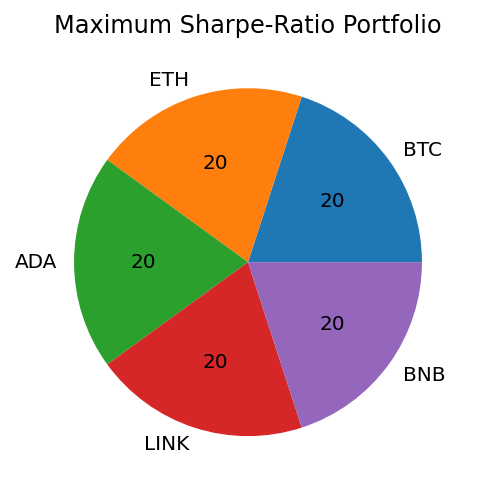

In [29]:
ef_capm = EfficientFrontier(mu_capm, sigma, weight_bounds = (0,1))
weights_capm = ef_capm.max_sharpe()
pd.Series(ef_capm.clean_weights()).plot.pie(labels = ["BTC", "ETH", "ADA", "LINK", "BNB"], autopct = my_autopct)
plt.ylabel("")
plt.title("Maximum Sharpe-Ratio Portfolio");

## MVO - Using Different Risk Model

The standard approach of quantifying asset risk in MVO consists of just using the sample covariance-matrix like we did above. However, it can be argued that this is carelessly throwing away a good deal of information, because covariance does not preserve the order of observations. In the case of time series, the order of the returns is of fundamental importance, thus we need some way of including the sequential nature of the data into the definition of covariance. This is where the exponentially-weighted covariance-matrix comes into play: rather than letting $(x_{i},y_{i})$ be any observations from the dataset, let us preserve the order by saying that $(x_{i},y_{i})$ denotes the returns of asset $X$ and $Y$ $i$ days ago. Thus $(x_{1}-\bar{x})(y_{1}-\bar{y})$ specifically refers to the co-variation of the returns yesterday. Now we simply give each co-variation term an exponential weight as follows: $\;\text{Cov}(x,y) = \frac{\alpha}{N-1}\sum^N_{i=1}(1-\alpha)^{i-1}(x_{i}-\bar{x})(y_{i}-\bar{y})$, where $\alpha$ represents the decay rate.

### Exponentially-Weighted Covariance Matrix

In [42]:
# using the exp_cov function for computation of the weighted matrix
from pypfopt.risk_models import exp_cov
sigma_exp = exp_cov(df, frequency = 365)
print(sigma_exp)

Symbols    BTC-USD   ETH-USD   ADA-USD  LINK-USD   BNB-USD
Symbols                                                   
BTC-USD   0.687791  0.613579  0.483308  0.556106  0.760637
ETH-USD   0.613579  1.077628  0.799466  0.908814  0.805258
ADA-USD   0.483308  0.799466  2.295298  0.959470  0.924539
LINK-USD  0.556106  0.908814  0.959470  1.780095  0.997497
BNB-USD   0.760637  0.805258  0.924539  0.997497  3.666217


In [43]:
variance_exp = np.sqrt(np.diag(w @ sigma_exp @ w.T))
sharp_ratio = returns / variance_exp

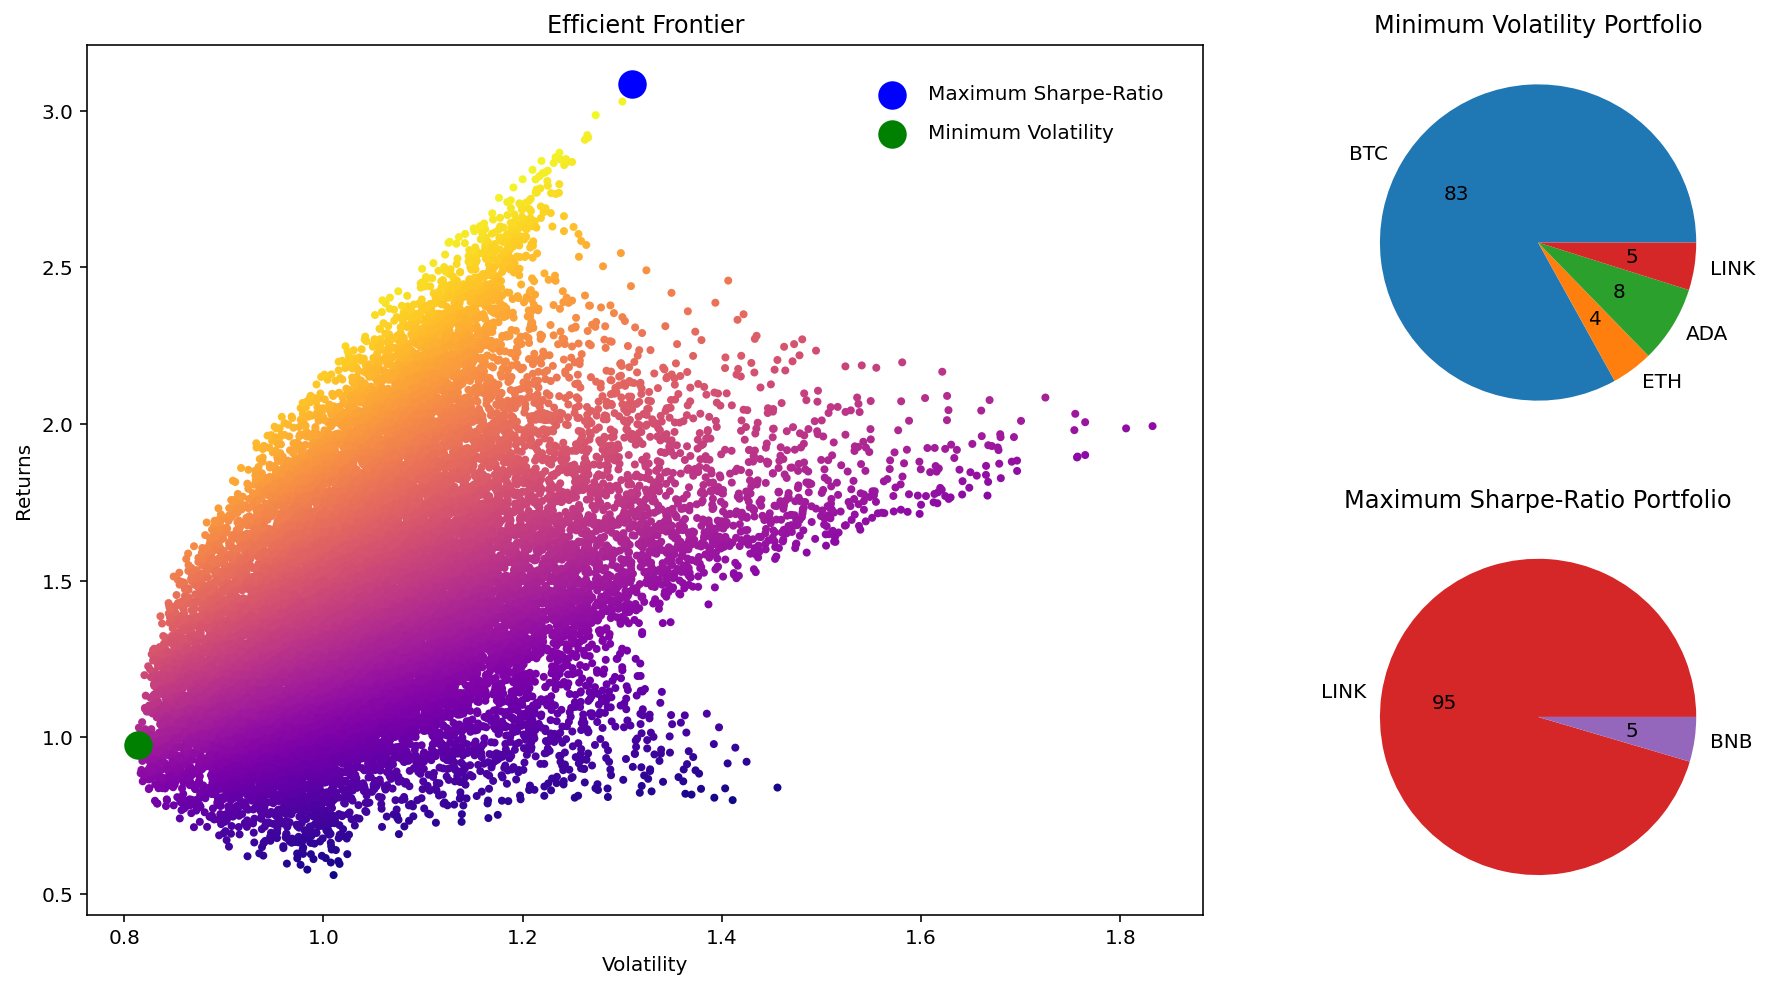

In [44]:
plotEF(returns, variance_exp, mu, sigma_exp, ["BTC", "ETH", "ADA", "LINK", "BNB"])

## Preliminary Conclusion

Despite their strong theoretical foundations, efficient frontier portfolios often have poor real-life performance due to estimation errors in the inputs. These errors mainly come from using mean historical returns as an estimator of future return. The easiest way to avoid this problem is to not provide the expected returns to the optimizer, and just optimize on the sample covariance matrix instead. Effectively we are saying that although previous returns won't predict future returns, previous risks might predict future risks. Empirical results support this, showing that minimum variance portfolios outperform standard MVO. In our case, we should therefore expect that the minimum variance portfolio - using the weighted covariance matrix - has the best performance among all other portfolios tested as of now, in relation to this notebook.

## Black-Litterman Allocation